# Correlation between airbag malfunction and injury




    
One of the most important safety features of a car is the airbag, which softens the blow on 
the occupant in the event of a crash. With the Takata airbag recall that took place over the past few years, which was a safety recall on over 8,000,000 faulty airbags installed in vehicles from 2002-2008, there has been much concern over airbags. Along with that, airbag malfunctions in general can prove to be very dangerous, but just how dangerous are they?
    
The goal of this report is to see if there is a correlation in the NHTSA database about complaints of airbag malfunction and reported injury and/or death. Are airbag malfunctions more dangerous than other malfunctions a vehicle can experience?
      

# Code



All of our necessary imports; we will be using json, numpy, and altair

In [1]:
import json
import requests
from os.path import exists,join
from os import makedirs
import numpy as np
import altair as alt
import pandas as pd

Here we are loading the data from the NHTSA complaint API. To make the loading times more reasonable, this code creates a local cache of vehicles that are called in the program for local access. We also have a get_complaints method to access information based on make, model, year.

In [2]:
url0 = 'http://www.nhtsa.gov/webapi/api/Complaints/vehicle/modelyear/{}/make/{}/model/{}?format=json'
def get_complaints(make,model,year):
    folder = 'NHTSAcomplaints'
    if not exists(folder): makedirs(folder)
    filename = make + '_' + model + '_' + str(year) + '.json'
    path = join(folder,filename)
    if exists( path ):
       # print('Have previously downloaded this: getting from local file')
        with open(path) as f:
            results = json.load(f)
    else:
        #print('Haven\'t downloaded this one yet: getting from NHTSA and will save to local file')
        url = url0.format(year,make,model)
        results = json.loads(requests.get(url).text)
        with open(path,'w') as f:
            json.dump(results,f,indent=3)
    return results

After understanding the keys and elements, it seemed like the most accurate route to gather information without having to look through every single car in the database (which would be extremely difficult, especially in terms of computing time) would be to look up a list of the best selling cars in the United States for 2019. Here, a car list is made with tuples of make and model for 10 vehicles that were listed as the best selling.

In [3]:
carlist = [('Toyota','Tacoma'),('Ford', 'Escape'), ('Honda','Civic'),
        ('Toyota','Corolla'),('Toyota','Camry'),('Chevrolet', 'Equinox'),('Honda','CR-V'),
        ('Chevrolet', 'Silverado'),('Honda','Accord'),('Nissan','Rogue')]
len(carlist)

10

Here, a dictionary is created that creates keys that are assigned to empty values. These values will be determined depending on how we access the information from each vehicle.

Make and model is placed into a singular variable; car. From there, a for loop is used to loop through the years(2000-2019) and then the get_complaints method is utilized to access information from the API. Now, count the total number of complaints in the count variable. Additional variables are created; c_d is total number of deaths, c_i is total number of injured, c_abd is total number of air bag related deaths, and c_abi is total number of air bag related injuries. A loop is used to extract total number of injuries and deaths, and then for those complaints about airbags, injuries and deaths are also tallied. They are all appended to the dictionary into the values for the keys. 

This method is able to to loop through all ten cars and all iterations (years) of them and append them to the list. 


In [4]:
data={'car':[], 'year':[], 'total':[], 'injured(all)':[], 'death(all)':[], 'airbag_death':[], 'airbag_injury':[]}
for car in carlist:
    make,model = car
    for year in range(2000,2019):
        d = get_complaints(make,model,year)
        count = d['Count']
        c_d,c_i =0,0
        c_abd, c_abi =0,0
        data['total'].append(count)
        for result in d['Results']:
            c_i += result['NumberOfInjured']
            c_d += result['NumberOfDeaths']
            if 'AIR BAGS' in result ['Component']:
                c_abi += result['NumberOfInjured']
                c_abd+= result['NumberOfDeaths']
        data['injured(all)'].append(c_i)     
        data['death(all)'].append(c_d)          
        data['airbag_injury'].append(c_abi)     
        data['airbag_death'].append(c_abd)

Looping through the entire length of the carlist, and then through the range of years, the make model is appended to the car key as "Make" followed by whitespace followed by "Model". The year is also appended to the dictionary on the year key. 

In [5]:
for i in range(len(carlist)):
    for j in range(2000,2019):
        data['car'].append(carlist[i][0]+ ' ' + carlist[i][1])
        data['year'].append(j)
        

Here, the amount of values in each key is tested to see if the keys have a uniform amount of values. Otherwise, it will make it difficult to create graphs with altair. 

In [6]:
for i in data.keys():
    print(i, len(data[i]))

car 190
year 190
total 190
injured(all) 190
death(all) 190
airbag_death 190
airbag_injury 190


In [7]:
test = {}
for car in carlist:
    make,model = car
    for year in range(2000,2019):
        d = get_complaints(make,model,year)
        if year not in test.keys():
            test[year] = d['Count']
            
test1 =  {v:k for k, v in test.items()}
print("the max amount of complaints is {} in year {}".format(max(test1), test1[max(test1)]))

the max amount of complaints is 727 in year 2006


Using PD.Dataframe the data is placed into a chart and the information can be checked to see if it is accurate. Each vehicle is separated into car (make, model) and year, followed by total complaints, total injuries, total deaths, total airbag deaths, and total airbag injuries. 

In [8]:
dataframe= pd.DataFrame.from_dict(data)
dataframe


,car,year,total,injured(all),death(all),airbag_death,airbag_injury
0,Toyota Tacoma,2000,198,17,0,0,13
1,Toyota Tacoma,2001,394,36,4,0,15
2,Toyota Tacoma,2002,309,21,0,0,13
3,Toyota Tacoma,2003,328,17,0,0,13
4,Toyota Tacoma,2004,372,20,0,0,12
5,Toyota Tacoma,2005,675,16,0,0,2
6,Toyota Tacoma,2006,727,29,0,0,4
7,Toyota Tacoma,2007,483,29,2,0,6
8,Toyota Tacoma,2008,371,27,4,0,16
9,Toyota Tacoma,2009,462,1,0,0,0


# Graphs

Now we are using altair to graph the information that we have extracted and placed into the dictionary. Here, a graph is made with total injuries that occurred based on car and year and airbag injuries that occurred using the same criteria.        

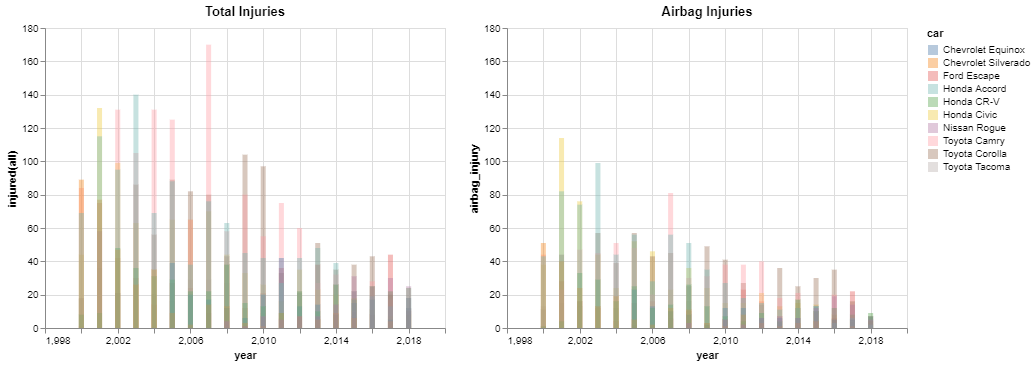

In [9]:
import altair as alt
alt.renderers.enable('notebook')
import pandas as pd
df =pd.DataFrame.from_dict(data)
chart1 = alt.Chart(df, title = 'Total Injuries').mark_bar(opacity=0.4).encode( x='year',y='injured(all)', color ='car'  )
chart2 = alt.Chart(df, title = 'Airbag Injuries').mark_bar(opacity=0.4).encode( x='year', y =alt.Y('airbag_injury', scale =alt.Scale(domain=(0,180))), color ='car')
alt.hconcat(chart1, chart2)


Here we are comparing the total deaths to total deaths where an airbag malfunction was reported. There seems to be quite a few deaths that correlated to airbags. 

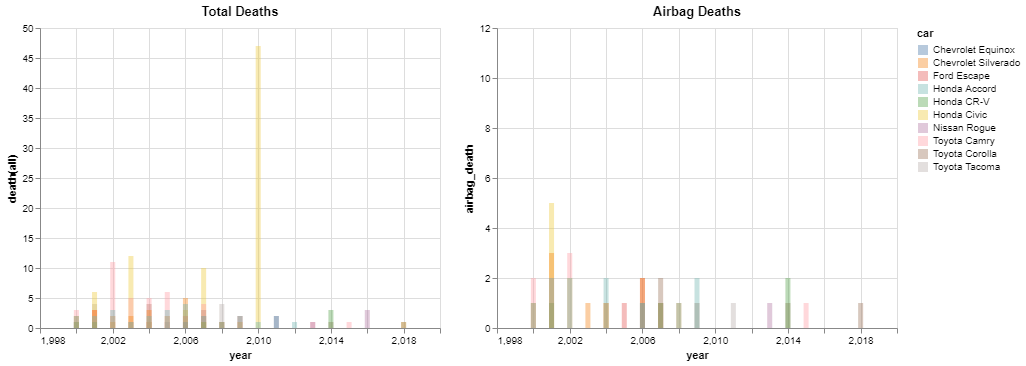

In [10]:
chart3 = alt.Chart(df, title = 'Total Deaths').mark_bar(opacity=0.4).encode( x='year',y='death(all)', color ='car'  )
chart4 = alt.Chart(df, title = 'Airbag Deaths').mark_bar(opacity=0.4).encode( x='year',y =alt.Y('airbag_death', scale =alt.Scale(domain=(0,12))), color ='car')
alt.hconcat(chart3, chart4)

# Analysis

Based on the graphs with the same scaling, we can see there is a high number of airbag related injuries/deaths that occur. Airbags are classified as one complaint among many others, and to see that at times they account for almost 50 percent of injuries or deaths per year is striking. 

There is also a jump in airbag malfunctions from the years of the Takata Airbag recall, which is interesting to see visualized.


# References 


1.  Takata Airbag Recall:  https://thomasjhenrylaw.com/blog/product-liability/takata-airbag-recall-a-complete-list-of-affected-vehicles/

2.  Altair help: https://altair-viz.github.io/user_guide/customization.html

3.  Best selling cars of 2019: https://www.caranddriver.com/news/g27041933/best-selling-cars-2019/?slide=15




